In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
#Function to Read Multiple Images
def read_images(basepath, num_images=100):
    
    #Generate File Names
    filenames = []
    for i in range(1,num_images+1):
        filename = basepath + '(' + str(i) + ').jpg'
        filenames.append(filename)
    
    #Read Images
    images = []
    for name in filenames:
        image = cv2.imread(name)
        images.append(image)
    
    return images

#Function to collect center coordinates of dice
def locateCenterCoords(cornerRect):
    cX = []
    cY = []
    for corners in cornerRect:
        x = int(np.sum(np.array(corners)[:,:,0]) / 4)
        y = int(np.sum(np.array(corners)[:,:,1]) / 4)
        cX.append(x)
        cY.append(y)

    cX, cY = np.array(cX), np.array(cY)
    return cX, cY

#Function to crop images of single die
def crop_images(image,cX, cY, translated_cornerRect):
    half_size = int(55/2)
    img2 = image
    cropped=[]
    for i in range(cX.size):
        cent_r, cent_c = cY[i], cX[i]
        cropped_sample = img2[cent_r-half_size:cent_r+half_size,cent_c-half_size:cent_c+half_size, :]

        translated_cornerRect[i,:,:,0] -= cX[i] - half_size
        translated_cornerRect[i,:,:,1] -= cY[i] - half_size

        translated_cornerRect[i,:,:,0] += np.sign(half_size+1 - translated_cornerRect[i,:,:,0]) * 2
        translated_cornerRect[i,:,:,1] += np.sign(half_size+1 - translated_cornerRect[i,:,:,1]) * 2

        mask = np.zeros((cropped_sample.shape))
        cv2.drawContours(mask, np.array([translated_cornerRect[i]]), -1, (1, 1, 1), -1)

        masked = cropped_sample * mask
        masked = masked.astype(int)

        new = np.ones((cropped_sample.shape)) * 255
        new[mask[:,:,:].astype(bool)] = cropped_sample[mask[:, :, : ].astype(bool)]

        cropped.append(new.astype('int'))
    return np.array(cropped)

#Function to get single-dice set for a set of images
def get_single_die(image_stack):
    single_set = []
    for img in image_stack:
        roi = img

        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        Blur = cv2.GaussianBlur(gray, (5,5), 1)
        ret, binarized = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

        contours = cv2.findContours(binarized[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

        cornerRect = []
        for i in contours:
            epsilon = 0.05*cv2.arcLength(i,True)
            approx = cv2.approxPolyDP(i,epsilon,True)
            if len(approx) == 4 and cv2.contourArea(i) > 20:
                cornerRect.append(approx)
        
        img2 = img
        translated_cornerRect = np.array(cornerRect)
        crow, ccol = locateCenterCoords(cornerRect)
        cropped = crop_images(img2,crow,ccol, translated_cornerRect)
        for cropped_single in cropped:
            single_set.append(cropped_single)
        
    return np.array(single_set)[:,:,:,:]

#Function to detect the number of dots in a die
def detect_die(image):
    gray = image[:,:,0]
    binarized = (gray < 120).astype(np.uint8) * 255
    contours, hierarchy = cv2.findContours(binarized, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    centercount = 0
    for c in contours:
        M = cv2.moments(c)
        area = cv2.contourArea(c)
        if area < 10:
            continue
        if M['m00'] ==0:
            continue
        centercount +=1
    return centercount

#Function to get total dice counts for a stack of images
def detect_dice(image_stack):
    single_dice = get_single_die(image_stack)
    
    # Initialize counters
    one = two = three = four = five = six = error = dice = 0

    for i in range(np.shape(single_dice)[0]):
        image = single_dice[i, :, :, :]
        num = detect_die(image)
        dice += 1

        if num == 1:
            one += 1
        elif num == 2:
            two += 1
        elif num == 3:
            three += 1
        elif num == 4:
            four += 1
        elif num == 5:
            five += 1
        elif num == 6:
            six += 1
        else:
            error += 1  # Catch any unexpected value

    # Display results
    print(f"Total Number of Dice: {dice}")
    print(f"one: {one}")
    print(f"two: {two}")
    print(f"three: {three}")
    print(f"four: {four}")
    print(f"five: {five}")
    print(f"six: {six}")
    print(f"error: {error}")

In [9]:
#Function to get total dice counts for a stack of images
def detect_dice(image_stack, show=True):
    one_tot = two_tot = three_tot = four_tot = five_tot = six_tot = error_tot = dice_tot = 0
    die_output = []
    for j in range(np.shape(image_stack)[0]):
        single_image = image_stack[j:j+1,:,:,:]
        if show:
            plt.figure()
            plt.imshow(single_image[0,:,:,:])
        single_dice = get_single_die(single_image)
    
        # Initialize counters
        one = two = three = four = five = six = error = dice = 0

        for i in range(np.shape(single_dice)[0]):
            image = single_dice[i, :, :, :]
            num = detect_die(image)
            die_output.append(num)
            dice += 1
            dice_tot += 1

            if num == 1:
                one += 1
                one_tot += 1
            elif num == 2:
                two += 1
                two_tot += 1
            elif num == 3:
                three += 1
                three_tot += 1
            elif num == 4:
                four += 1
                four_tot += 1
            elif num == 5:
                five += 1
                five_tot += 1
            elif num == 6:
                six += 1
                six_tot += 1
            else:
                error += 1  # Catch any unexpected value
                error_tot += 1
        if show:
            plt.title(f"image # {j+1}")
            plt.text(0.81, 0.5, f"Total Number of Dice: {dice}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
            plt.text(0.81, 0.45, f"one: {one}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
            plt.text(0.81, 0.4, f"two: {two}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
            plt.text(0.81, 0.35, f"three: {three}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
            plt.text(0.81, 0.3, f"four: {four}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
            plt.text(0.81, 0.25, f"five: {five}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
            plt.text(0.81, 0.2, f"six: {six}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
            plt.text(0.81, 0.15, f"error: {error}", va='center', rotation='horizontal', fontsize=12, transform=plt.gcf().transFigure)
        
    print(f"Total Number of Dice: {dice_tot}")
    print(f"one: {one_tot}")
    print(f"two: {two_tot}")
    print(f"three: {three_tot}")
    print(f"four: {four_tot}")
    print(f"five: {five_tot}")
    print(f"six: {six_tot}")
    print(f"error: {error_tot}")

    return die_output

In [4]:
image_set = np.array(read_images('dataset-images/Dice ', num_images=11000))

Total Number of Dice: 63
one: 6
two: 15
three: 13
four: 6
five: 15
six: 8
error: 0


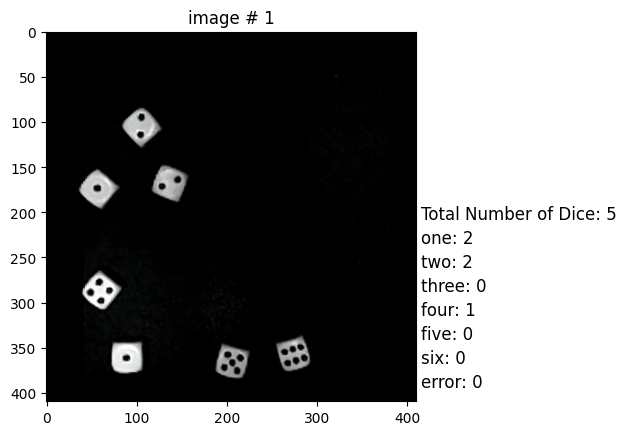

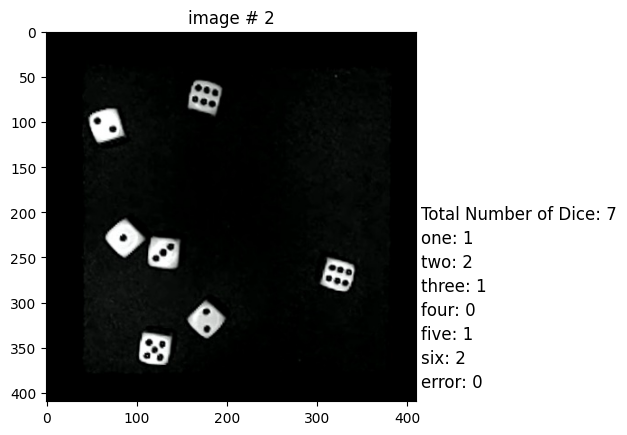

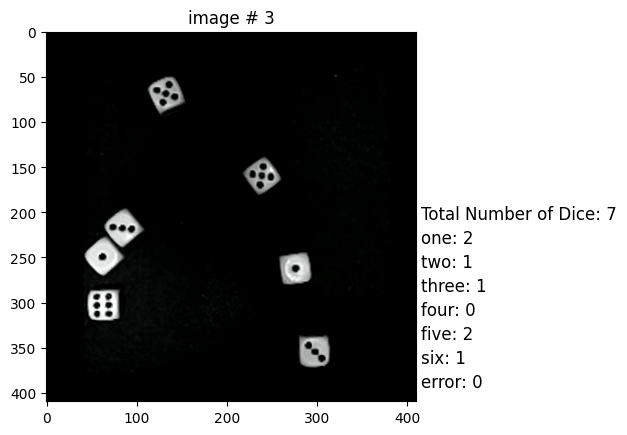

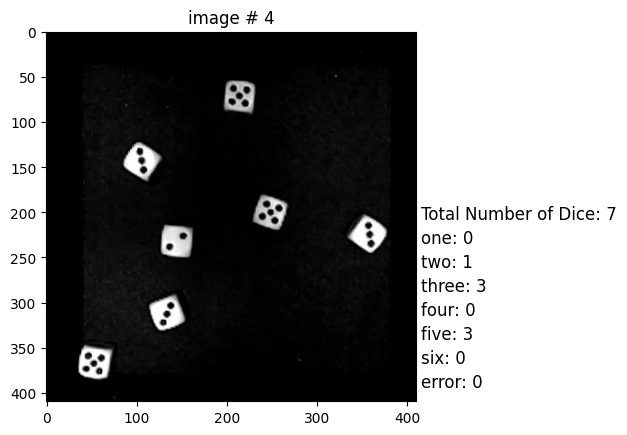

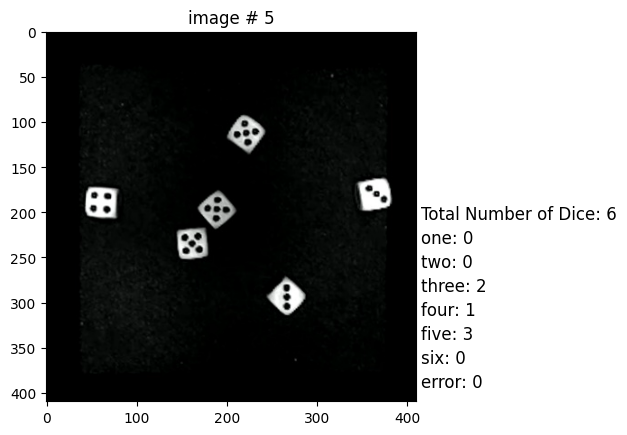

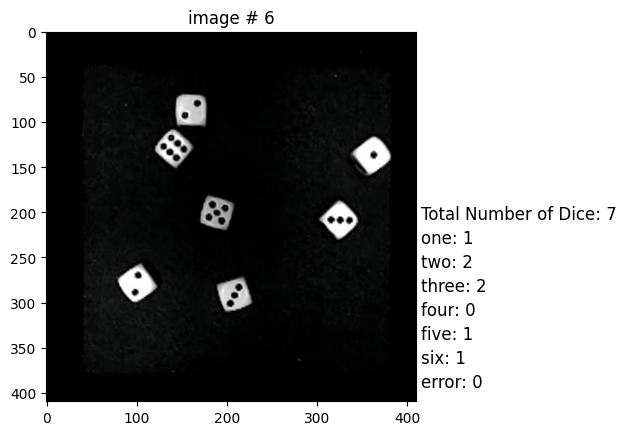

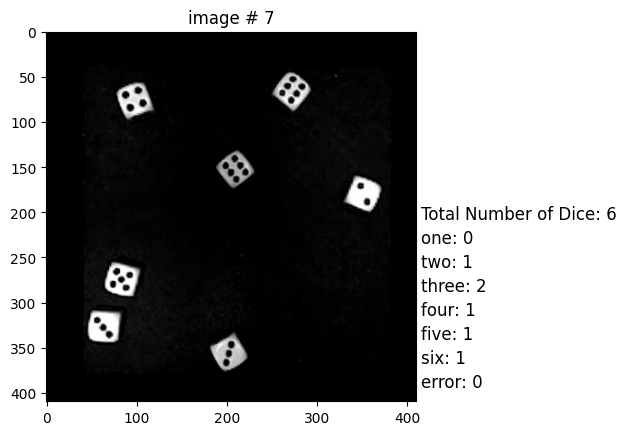

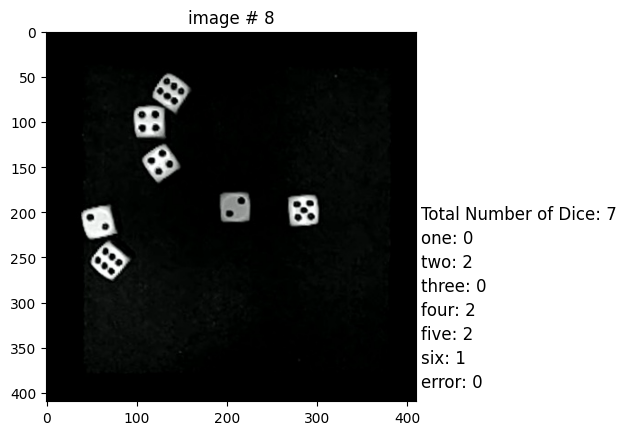

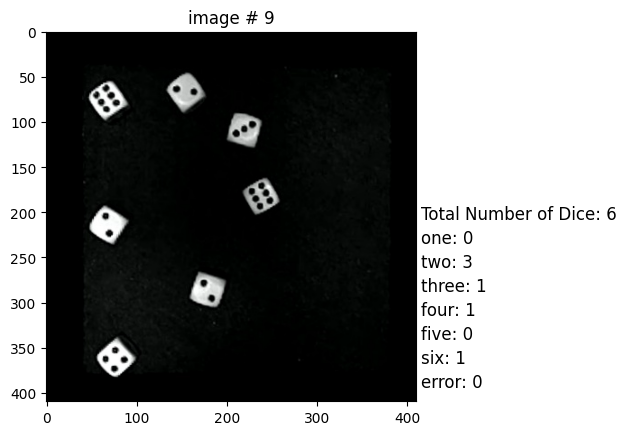

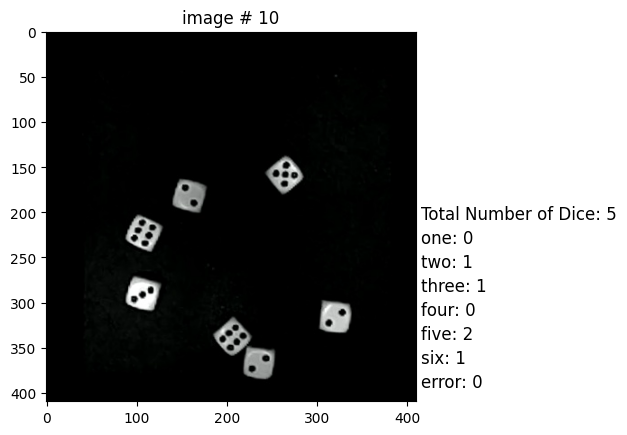

In [24]:
out = detect_dice(image_set[10000:10010], show=True)

In [19]:
def central_limit(image_stack, n_trials, binning=10):
    output = detect_dice(image_stack, show=False)
    subset = np.shape(output)[0]//n_trials
    new_set = output[0:(subset)*n_trials]
    subsets = np.reshape(new_set,(n_trials,subset))
    means = np.average(subsets, axis=0)
    plt.hist(means, edgecolor='black', bins=binning)
    plt.xlabel(f"Average of {n_trials} dice rolls")
    plt.ylabel("Frequency")
    plt.show()

Total Number of Dice: 67226
one: 11446
two: 11382
three: 11082
four: 11139
five: 11748
six: 9736
error: 693


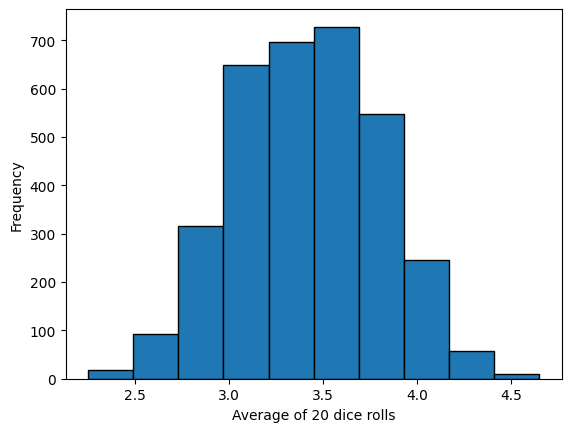

In [28]:
central_limit(image_set, 20)